In [1]:
import nltk; nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/johnohakim/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

## Prepare Stopwords

In [19]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['http','https','www','com','@','...','…', 'var', 'ref', 'document', 
             'referrer', 'var', 'bbpath', 'href', 'archive', 'function', 'beige',
            'book', 'federal', 'reserve', 'summary', 'indexof', 'backtoresults',
            'history', 'go', 'else', 'window', 'location', 'back', 'search',
            'this', 'report', 'prepared', 'federal', 'reserve', 'bank', 'summarizes',
            'january', 'february', 'march', 'april', 'may', 'june', 'july', 'august',
            'september', 'october', 'november', 'december', 'atlanta', 'boston', 'chicago',
            'cleveland', 'dallas', 'kansas', 'minneapolis', 'york', 'philadelphia', 
             'richmond', 'san', 'francisco', 'st', 'louis', 'officials', 'comments', 
             'views', 'commentary', 'national', 'based', 'information', 'collected',
             'received', 'contacts', 'outside', 'system', 'page', 'url', 'link', 
                   'district', 'districts'])



In [20]:
df = pd.read_csv('./data/beige_book_national.csv')
df.drop(columns='Unnamed: 0', inplace=True)
df.head()

,national_report,date
0,\n\r\n var ref = document.referrer;\r\n ...,2019-04
1,\n\r\n var ref = document.referrer;\r\n ...,2019-03
2,\n\r\n var ref = document.referrer;\r\n ...,2019-01
3,\n\r\n var ref = document.referrer;\r\n ...,2018-12
4,\n\r\n var ref = document.referrer;\r\n ...,2018-10


## Remove Special Characters

In [21]:
# Convert to list
data = df['national_report'].values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

[' var ref = document.referrer; var bBPath = beige-book-archive; function '
 'backToResults() { if (ref.indexOf(bBPath) > -1) { history.go(-1); } else { '
 'window.location.href = "./"; } } ‹ Back to Archive Search Beige Book: '
 'National Summary April 17, 2019 This report was prepared at the Federal '
 'Reserve Bank of St. Louis based on information collected on or before April '
 '8, 2019. This document summarizes comments received from contacts outside '
 'the Federal Reserve System and is not a commentary on the views of Federal '
 'Reserve officials. Overall Economic Activity Economic activity expanded at a '
 'slight-to-moderate pace in March and early April. While most Districts '
 'reported that growth continued at a similar pace as the previous report, a '
 'few Districts reported some strengthening. There was little change in the '
 'outlook among contacts in reporting Districts, with those expecting '
 'slight-to-modest growth in the months ahead. Reports on consumer spendi

## Tokenize words and Clean-up text

In [22]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['var', 'ref', 'document', 'referrer', 'var', 'bbpath', 'beige', 'book', 'archive', 'function', 'backtoresults', 'if', 'ref', 'indexof', 'bbpath', 'history', 'go', 'else', 'window', 'location', 'href', 'back', 'to', 'archive', 'search', 'beige', 'book', 'national', 'summary', 'april', 'this', 'report', 'was', 'prepared', 'at', 'the', 'federal', 'reserve', 'bank', 'of', 'st', 'louis', 'based', 'on', 'information', 'collected', 'on', 'or', 'before', 'april', 'this', 'document', 'summarizes', 'comments', 'received', 'from', 'contacts', 'outside', 'the', 'federal', 'reserve', 'system', 'and', 'is', 'not', 'commentary', 'on', 'the', 'views', 'of', 'federal', 'reserve', 'officials', 'overall', 'economic', 'activity', 'economic', 'activity', 'expanded', 'at', 'slight', 'to', 'moderate', 'pace', 'in', 'march', 'and', 'early', 'april', 'while', 'most', 'districts', 'reported', 'that', 'growth', 'continued', 'at', 'similar', 'pace', 'as', 'the', 'previous', 'report', 'few', 'districts', 'report

## Creating Bigram and Trigram Models

In [23]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=3, threshold=20) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=20)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['var_ref_document_referrer', 'var_bbpath_beige_book', 'archive_function_backtoresults_if', 'ref_indexof_bbpath_history', 'go_else_window_location', 'href_back', 'to', 'archive_search_beige_book', 'national_summary_april', 'this', 'report', 'was', 'prepared_at', 'the', 'federal_reserve_bank', 'of', 'st_louis', 'based_on', 'information_collected_on', 'or_before', 'april', 'this_document_summarizes_comments', 'received_from_contacts_outside', 'the', 'federal_reserve_system', 'and', 'is_not_commentary', 'on', 'the', 'views', 'of', 'federal_reserve_officials_overall', 'economic', 'activity', 'economic', 'activity', 'expanded', 'at', 'slight', 'to', 'moderate_pace', 'in', 'march', 'and', 'early_april', 'while', 'most', 'districts', 'reported', 'that', 'growth', 'continued', 'at', 'similar', 'pace', 'as', 'the', 'previous_report', 'few', 'districts', 'reported', 'some', 'strengthening', 'there', 'was', 'little_change', 'in', 'the', 'outlook', 'among', 'contacts', 'in', 'reporting', 'district

## Remove Stopwords, Make Bigrams and Lemmatize

In [24]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [25]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['overall', 'economic', 'activity', 'economic', 'activity', 'expand', 'slight', 'moderate_pace', 'early', 'report', 'growth', 'continue', 'similar', 'pace', 'previous', 'report', 'strengthen', 'little_change', 'outlook', 'report', 'expect', 'slight', 'modest', 'growth', 'months_ahead', 'report', 'consumer_spend', 'mixed', 'suggest', 'sluggish', 'sale', 'general', 'retailer', 'auto_dealer', 'report', 'tourism', 'generally', 'upbeat', 'report', 'loan', 'demand', 'mix', 'indicate', 'steady', 'growth', 'report', 'manufacturing', 'activity', 'favorable', 'many', 'note', 'trade', 'relate', 'uncertainty', 'report', 'strong', 'home', 'sale', 'note', 'low', 'demand', 'higher_priced', 'home', 'report', 'agricultural', 'condition', 'remain', 'weak', 'express', 'concern', 'impact', 'current', 'future', 'rainfall', 'flooding', 'employment', 'wage', 'employment', 'continue', 'increase', 'nationwide', 'report', 'modest', 'moderate', 'growth', 'report', 'slight', 'growth', 'report', 'gain', 'variety'

## Create the Dictionary and Corpus needed for Topic Modeling

In [26]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 23), (3, 1), (4, 1), (5, 1), (6, 3), (7, 1), (8, 1), (9, 1), (10, 6), (11, 1), (12, 2), (13, 1), (14, 1), (15, 1), (16, 1), (17, 4), (18, 1), (19, 4), (20, 2), (21, 1), (22, 1), (23, 1), (24, 2), (25, 1), (26, 1), (27, 1), (28, 1), (29, 2), (30, 6), (31, 1), (32, 2), (33, 4), (34, 2), (35, 2), (36, 2), (37, 9), (38, 4), (39, 2), (40, 2), (41, 2), (42, 1), (43, 1), (44, 2), (45, 1), (46, 11), (47, 1), (48, 1), (49, 1), (50, 2), (51, 12), (52, 1), (53, 5), (54, 1), (55, 2), (56, 1), (57, 1), (58, 1), (59, 9), (60, 2), (61, 4), (62, 1), (63, 1), (64, 1), (65, 1), (66, 2), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 7), (73, 1), (74, 1), (75, 2), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1), (81, 1), (82, 3), (83, 1), (84, 1), (85, 1), (86, 2), (87, 3), (88, 13), (89, 1), (90, 1), (91, 1), (92, 1), (93, 1), (94, 1), (95, 1), (96, 2), (97, 3), (98, 1), (99, 3), (100, 2), (101, 6), (102, 21), (103, 2), (104, 3), (105, 1), (106, 1), (107, 2), (108, 1), (109, 1), (11

Gensim creates a unique id for each word in the document. The corpus shown above is a mapping of (word_id, word_frequency).

In [27]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('ability', 1),
  ('accelerate', 1),
  ('activity', 23),
  ('additional', 1),
  ('agricultural', 1),
  ('already', 1),
  ('also', 3),
  ('attract', 1),
  ('auto_dealer', 1),
  ('bad', 1),
  ('balance', 6),
  ('bank', 1),
  ('banker', 2),
  ('banking', 1),
  ('benefit', 1),
  ('bonus', 1),
  ('brief', 1),
  ('business', 4),
  ('challenge', 1),
  ('change', 4),
  ('cite', 2),
  ('city', 1),
  ('climb', 1),
  ('commercial', 1),
  ('commercial_real', 2),
  ('commodity', 1),
  ('commonly', 1),
  ('company', 1),
  ('concentrate', 1),
  ('concern', 2),
  ('condition', 6),
  ('considerably', 1),
  ('constrain', 2),
  ('construction', 4),
  ('consumer', 2),
  ('consumer_spend', 2),
  ('consumer_spending', 2),
  ('continue', 9),
  ('cost', 4),
  ('crop', 2),
  ('current', 2),
  ('customer', 2),
  ('deceleration', 1),
  ('decline', 1),
  ('decrease', 2),
  ('delinquency_rate', 1),
  ('demand', 11),
  ('difficulties_finding', 1),
  ('drive', 1),
  ('due', 1),
  ('early', 2),
  ('economic', 12),


## Building the Topic Model

In [32]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [33]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.023*"report" + 0.021*"sale" + 0.017*"strong" + 0.014*"construction" + '
  '0.014*"loan" + 0.013*"increase" + 0.011*"demand" + 0.011*"continue" + '
  '0.010*"price" + 0.010*"new"'),
 (1,
  '0.044*"report" + 0.028*"increase" + 0.026*"activity" + 0.019*"city" + '
  '0.019*"note" + 0.017*"new" + 0.016*"sale" + 0.016*"price" + 0.015*"demand" '
  '+ 0.013*"growth"'),
 (2,
  '0.026*"report" + 0.013*"bank" + 0.011*"sale" + 0.011*"business" + '
  '0.010*"new" + 0.010*"increase" + 0.010*"demand" + 0.010*"continue" + '
  '0.008*"price" + 0.008*"expect"'),
 (3,
  '0.038*"report" + 0.020*"sale" + 0.017*"price" + 0.016*"new" + '
  '0.015*"activity" + 0.015*"city" + 0.015*"demand" + 0.014*"note" + '
  '0.012*"remain" + 0.011*"weak"')]


## Compute Model Perplexity and Coherence Score

In [36]:
# Compute Perplexity
print('\nPerplexity: ', round(lda_model.log_perplexity(corpus), 3))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', round(coherence_lda, 3))


Perplexity:  -6.56

Coherence Score:  0.254


In [37]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.088860  0.014678       1        1  41.577606
3      0.065394  0.022187       2        1  25.907263
0     -0.034954 -0.084806       3        1  20.606541
2     -0.119300  0.047941       4        1  11.908589, topic_info=     Category         Freq          Term        Total  loglift  logprob
11    Default   808.000000          bank   808.000000  30.0000  30.0000
210   Default  1252.000000           say  1252.000000  29.0000  29.0000
122   Default  2073.000000          loan  2073.000000  28.0000  28.0000
17    Default  1585.000000      business  1585.000000  27.0000  27.0000
108   Default  1149.000000     inventory  1149.000000  26.0000  26.0000
237   Default  2788.000000        strong  2788.000000  25.0000  25.0000
88    Default  1856.000000        growth  1856.000000  24.0000  24.0000
260   Default  1234.000000          weak  1234.000000  23.0000  23.0000
61    Default  1237.000000        expect  1237.000000  22.0000  22.0000
104   Default  1483.000000      industry  1483.000000  21.0000  21.0000
272   Default   592.000000        appear   592.000000  20.0000  20.0000
745   Default   648.000000      strength   648.000000  19.0000  19.0000
209   Default  4750.000000          sale  4750.000000  18.0000  18.0000
141   Default   830.000000        modest   830.000000  17.0000  17.0000
197   Default  9720.000000        report  9720.000000  16.0000  16.0000
188   Default   836.000000          rate   836.000000  15.0000  15.0000
83    Default   751.000000          good   751.000000  14.0000  14.0000
274   Default  1084.000000          area  1084.000000  13.0000  13.0000
33    Default  2453.000000  construction  2453.000000  12.0000  12.0000
53    Default   751.000000    employment   751.000000  11.0000  11.0000
51    Default   835.000000      economic   835.000000  10.0000  10.0000
367   Default   606.000000         steel   606.000000   9.0000   9.0000
1044  Default   432.000000       percent   432.000000   8.0000   8.0000
926   Default   202.000000      recovery   202.000000   7.0000   7.0000
105   Default   174.000000     inflation   174.000000   6.0000   6.0000
161   Default   749.000000         order   749.000000   5.0000   5.0000
317   Default   747.000000   improvement   747.000000   4.0000   4.0000
219   Default   470.000000      shortage   470.000000   3.0000   3.0000
1875  Default   142.000000        strike   142.000000   2.0000   2.0000
34    Default   986.000000      consumer   986.000000   1.0000   1.0000
...       ...          ...           ...          ...      ...      ...
61     Topic4   254.852890        expect  1237.061523   0.5481  -4.8431
823    Topic4   137.830902       mention   442.541260   0.9614  -5.4577
108    Topic4   227.222961     inventory  1149.588501   0.5067  -4.9578
51     Topic4   183.707718      economic   835.713196   0.6130  -5.1704
188    Topic4   182.851517          rate   836.734680   0.6071  -5.1751
37     Topic4   318.923950      continue  2856.674805  -0.0646  -4.6188
104    Topic4   229.573959      industry  1483.166870   0.2622  -4.9475
209    Topic4   368.349213          sale  4750.180176  -0.4290  -4.4747
150    Topic4   337.520569           new  3948.786133  -0.3316  -4.5621
46     Topic4   325.908020        demand  3697.873291  -0.3010  -4.5971
53     Topic4   166.677734    employment   751.393921   0.6220  -5.2677
367    Topic4   147.059937         steel   606.190369   0.7116  -5.3929
102    Topic4   336.075623      increase  4873.117676  -0.5462  -4.5664
206    Topic4   216.003357          rise  1622.502197   0.1115  -5.0085
122    Topic4   231.618851          loan  2073.990234  -0.0642  -4.9387
274    Topic4   176.431900          area  1084.127075   0.3123  -5.2108
178    Topic4   255.178864         price  3807.677979  -0.5749  -4.8418
317    Topic4   151.085663   improvement   747.579590   0.5289  -5.3659
99     Topic4   174.119446       

## Building LDA Mallet Model

In [46]:
!ls

Data                        Topic_Model_Viz.ipynb
Data_Gathering.ipynb        Topic_Modeling_Gensim.ipynb
Data_Gathering_2.ipynb      capstone
Data_Gathering_3.ipynb      full_list.txt
Data_Gathering_4.ipynb      mallet-2.0.8
EDA.ipynb                   mallet-2.0.8.zip
EDA_2.ipynb                 text_mining
Images                      text_mining.zip


In [50]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = 'mallet-2.0.8/bin/mallet' 
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=4, id2word=id2word)

In [52]:
# Show Topics
pprint(ldamallet.show_topics(formatted=True))

[(0,
  '0.018*"report" + 0.017*"business" + 0.016*"bank" + 0.016*"expect" + '
  '0.014*"continue" + 0.014*"inventory" + 0.011*"demand" + 0.010*"loan" + '
  '0.009*"rate" + 0.008*"industry"'),
 (1,
  '0.047*"increase" + 0.041*"activity" + 0.039*"report" + 0.021*"growth" + '
  '0.019*"price" + 0.018*"continue" + 0.017*"note" + 0.016*"remain" + '
  '0.014*"firm" + 0.013*"sector"'),
 (2,
  '0.043*"sale" + 0.034*"strong" + 0.024*"increase" + 0.023*"price" + '
  '0.021*"construction" + 0.016*"high" + 0.015*"loan" + 0.015*"area" + '
  '0.013*"continue" + 0.013*"industry"'),
 (3,
  '0.091*"report" + 0.045*"city" + 0.037*"note" + 0.034*"demand" + '
  '0.025*"decline" + 0.022*"sale" + 0.020*"activity" + 0.017*"price" + '
  '0.016*"weak" + 0.015*"low"')]


In [54]:
# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', round(coherence_ldamallet, 3))


Coherence Score:  0.278


## Optimal number of topics

In [55]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [56]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        texts=data_lemmatized, 
                                                        start=2, 
                                                        limit=40, 
                                                        step=6)


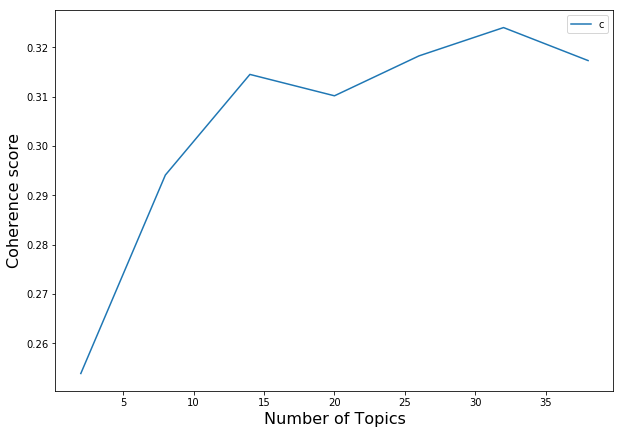

In [61]:
limit=40; start=2; step=6;
x = range(start, limit, step)

plt.figure(figsize=(10, 7))
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics", fontsize=16)
plt.ylabel("Coherence score", fontsize=16)
plt.legend(("coherence_values"), loc='best')
plt.show()

In [58]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.2539
Num Topics = 8  has Coherence Value of 0.2941
Num Topics = 14  has Coherence Value of 0.3145
Num Topics = 20  has Coherence Value of 0.3101
Num Topics = 26  has Coherence Value of 0.3182
Num Topics = 32  has Coherence Value of 0.324
Num Topics = 38  has Coherence Value of 0.3173


From the graph, we observe an intial peak at 14, before the dip and then the rise again. We will choose the point with the initial rise as our optimal number of topics.  

In [63]:
# Select the model and print the topics
optimal_model = model_list[2]
model_topics = optimal_model.show_topics(formatted=True)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.059*"activity" + 0.038*"growth" + 0.034*"continue" + 0.032*"price" + '
  '0.029*"remain" + 0.027*"increase" + 0.025*"sector" + 0.024*"wage" + '
  '0.022*"economic" + 0.022*"modest"'),
 (1,
  '0.041*"note" + 0.037*"loan" + 0.037*"demand" + 0.029*"increase" + '
  '0.028*"construction" + 0.025*"crop" + 0.024*"gain" + 0.021*"price" + '
  '0.017*"lending" + 0.017*"industry"'),
 (2,
  '0.188*"report" + 0.063*"sale" + 0.051*"strong" + 0.037*"activity" + '
  '0.035*"construction" + 0.028*"city" + 0.026*"good" + 0.022*"generally" + '
  '0.021*"retail" + 0.020*"industry"'),
 (3,
  '0.067*"increase" + 0.046*"high" + 0.043*"rise" + 0.032*"sale" + '
  '0.029*"note" + 0.028*"firm" + 0.026*"production" + 0.024*"manufacturer" + '
  '0.024*"business" + 0.016*"retailer"'),
 (4,
  '0.064*"remain" + 0.060*"sale" + 0.044*"continue" + 0.043*"weak" + '
  '0.034*"improvement" + 0.032*"level" + 0.026*"activity" + 0.022*"improve" + '
  '0.021*"generally" + 0.020*"accord"'),
 (5,
  '0.111*"report" + 0.

## Finding the dominant topic in each sentence

In [65]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.4915,"activity, growth, continue, price, remain, inc...",var ref = document.referrer; var bBPath = bei...
1,1,0.0,0.4953,"activity, growth, continue, price, remain, inc...",var ref = document.referrer; var bBPath = bei...
2,2,0.0,0.5140,"activity, growth, continue, price, remain, inc...",var ref = document.referrer; var bBPath = bei...
3,3,0.0,0.5575,"activity, growth, continue, price, remain, inc...",var ref = document.referrer; var bBPath = bei...
4,4,0.0,0.5666,"activity, growth, continue, price, remain, inc...",var ref = document.referrer; var bBPath = bei...
5,5,0.0,0.6261,"activity, growth, continue, price, remain, inc...",var ref = document.referrer; var bBPath = bei...
6,6,0.0,0.6140,"activity, growth, continue, price, remain, inc...",var ref = document.referrer; var bBPath = bei...
7,7,0.0,0.5257,"activity, growth, continue, price, remain, inc...",var ref = document.referrer; var bBPath = bei...
8,8,0.0,0.5656,"activity, growth, continue, price, remain, inc...",var ref = document.referrer; var bBPath = bei...
9,9,0.0,0.5695,"activity, growth, continue, price, remain, inc...",var ref = document.referrer; var bBPath = bei...


In [66]:
df_dominant_topic.tail()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
424,424,10.0,0.1802,"report, bank, respondent, concern, business, n...",var ref = document.referrer; var bBPath = bei...
425,425,10.0,0.2619,"report, bank, respondent, concern, business, n...",var ref = document.referrer; var bBPath = bei...
426,426,10.0,0.3391,"report, bank, respondent, concern, business, n...",var ref = document.referrer; var bBPath = bei...
427,427,10.0,0.2999,"report, bank, respondent, concern, business, n...",var ref = document.referrer; var bBPath = bei...
428,428,10.0,0.3636,"report, bank, respondent, concern, business, n...",var ref = document.referrer; var bBPath = bei...


## Find the most representative document for each topic

In [69]:
# Group top 14 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head(14)

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.6261,"activity, growth, continue, price, remain, inc...",var ref = document.referrer; var bBPath = bei...
1,1.0,0.3090,"note, loan, demand, increase, construction, cr...",var ref = document.referrer; var bBPath = bei...
2,2.0,0.2709,"report, sale, strong, activity, construction, ...",var ref = document.referrer; var bBPath = bei...
3,3.0,0.2089,"increase, high, rise, sale, note, firm, produc...",var ref = document.referrer; var bBPath = bei...
4,4.0,0.2477,"remain, sale, continue, weak, improvement, lev...",var ref = document.referrer; var bBPath = bei...
5,5.0,0.3007,"report, demand, note, city, activity, increase...",var ref = document.referrer; var bBPath = bei...
6,6.0,0.3550,"report, city, increase, note, price, activity,...",var ref = document.referrer; var bBPath = bei...
7,7.0,0.3048,"inventory, expect, loan, rate, industry, housi...",var ref = document.referrer; var bBPath = bei...
8,8.0,0.2696,"demand, business, loan, sector, mention, area,...",File Not Found The page or object you request...
9,9.0,0.3601,"report, increase, growth, city, strong, sale, ...",var ref = document.referrer; var bBPath = bei...


## Topic distribution across documents

In [73]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics.head(14)

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,0.0,"activity, growth, continue, price, remain, inc...",20.0,0.0466
1,0.0,"activity, growth, continue, price, remain, inc...",24.0,0.0559
2,0.0,"activity, growth, continue, price, remain, inc...",21.0,0.0490
3,0.0,"activity, growth, continue, price, remain, inc...",3.0,0.0070
4,0.0,"activity, growth, continue, price, remain, inc...",13.0,0.0303
5,0.0,"activity, growth, continue, price, remain, inc...",48.0,0.1119
6,0.0,"activity, growth, continue, price, remain, inc...",63.0,0.1469
7,0.0,"activity, growth, continue, price, remain, inc...",58.0,0.1352
8,0.0,"activity, growth, continue, price, remain, inc...",12.0,0.0280
9,0.0,"activity, growth, continue, price, remain, inc...",27.0,0.0629
